## Обработка изображений. Задание 2

__Володин Сергей__, группа 374

Цель работы: классификация геоглифов пустыни Наска.

 * Вход: изображения геоглифов (BMP)
 * Число классов: 7

Типы геоглифов:
 * Схематичный, неискаженный
 * Схематичный, искаженный
 * Фото со спутника

In [189]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io, morphology
from pandas import DataFrame as df
from scipy.ndimage.morphology import binary_fill_holes
from joblib import Parallel, delayed
import multiprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn.metrics import accuracy_score

## Параметры

In [195]:
# Количество итераций для очистки скелета
prune_skeleton_n = 10

# Порог
image_thresold = 100

## Метки классов

In [181]:
# Заполнение меток
num_per_class = 4
N = len(imc.files)
y = np.zeros((N, ), dtype = np.int32)
for i in range(N):
    y[i] = i / num_per_class
n_classes = np.max(y) + 1

## Загрузка изображений

In [93]:
# Загрузка изображений
imc = skimage.io.imread_collection("Geogliph_1/*")

## Функции для работы с геоглифами

In [83]:
def binarize(im):
    ''' Бинаризация изображения '''
    im_gray = np.average(im, axis = 2)
    im_bin = 1. * (im_gray < image_thresold)
    return(im_bin)

def skeletonize(im_bin):
    ''' Скелетонизация '''
    #im_sk = skimage.morphology.thin(im_bin)
    #im_sk = skimage.morphology.skeletonize(im_bin)
    im_sk = skimage.morphology.skeletonize_3d(im_bin) / 255.
    return(im_sk)

In [ ]:
def neighbours(im, i, j, step = 1):
    ''' Соседи для данного пиксела '''
    (x, y) = im.shape
    return im[max(0, i - step):min(i + step + 1, x),max(0, j - step):min(j + step + 1, y)]

def count_neighbours(im):
    ''' Подсчитать количество соседей для каждого пиксела  '''
    res = np.zeros(9)
    
    neighbours_arr = np.zeros(im.shape)
    
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if im[i][j] > 0:
                neighbours_arr[i][j] = int(max(np.sum(neighbours(im, i, j)) - 1, 0))

    return neighbours_arr

In [58]:
def get_leaves(n_arr):
    ''' Вернуть листовые пикселы '''
    mask = 1. * (n_arr == 1)
    return np.sum(mask), mask

def get_intersections(n_arr):
    ''' Вернуть пикселы, соответствующие пересечениям в скелете '''
    mask = 1. * (n_arr > 2)
    result = np.zeros(n_arr.shape)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j] and np.sum(neighbours(result, i, j, 3)) == 0:
                result[i][j] = 1
    return np.sum(result), result

In [60]:
def prune_skeleton(im_sk, size = 0):
    ''' Прореживание скелета: удаление коротких отростков '''
    im_sk = 1 * (im_sk > 0)
    for i in range(size):
        _, endpoints = get_leaves(count_neighbours(im_sk))
        endpoints = np.logical_not(endpoints)
        im_sk = np.logical_and(im_sk, endpoints)
    return 1. * im_sk

In [66]:
def construct_preview(im_sk, m_l, m_i):
    ''' Визуализация скелета (синий) с листовыми вершинами (красные) и пересечениями (зеленые )'''
    res = np.zeros((im_sk.shape[0], im_sk.shape[1], 3))
    res[:, :, 2] = im_sk * 1.
    res[:, :, 0] = m_l * 1.
    res[:, :, 1] = m_i * 1.
    return res

In [95]:
def process_image(im):
    ''' Бинаризация, построение скелета, визуализация, подсчет признаков '''
    im_bin = binarize(im)
    im_sk = skeletonize(im_bin)
    im_sk = prune_skeleton(im_sk, prune_skeleton_n)
    n_arr = count_neighbours(im_sk)
    c_l, m_l = get_leaves(n_arr)
    c_i, m_i = get_intersections(n_arr)
    preview = 2 * (construct_preview(im_sk, m_l, m_i) - 0.5)
    return c_l, c_i, im_bin, im_sk, preview

# Получение признаков

In [ ]:
def process_shot(i, imc = imc):
    ''' Получить признаки для индекса i в коллекции '''
    c_l, c_i, _, _, _ = process_image(imc[i])
    return c_l, c_i

In [173]:
cmap = plt.cm.get_cmap('RdYlBu')
def plot_features(features, labels, marker = '.'):
    ''' Распределение признаков и одинаковые классы '''
    plt.scatter(features[:,0], features[:,1], c = labels, cmap = cmap, marker = marker)
def plot_title():
    plt.title('Feature distribution')
    plt.xlabel('Leaves')
    plt.ylabel('Intersections')
def plot_lines(features, labels):
    N = features.shape[0]
    for i in range(N):
        p1 = (features[i,0], features[i,1])
        for j in range(N):
            p2 = (features[j,0], features[j,1])
            if labels[i] == labels[j]:
                plt.plot((p1[0], p2[0]), (p1[1], p2[1]), color='gray', alpha = 0.05)

In [100]:
def get_features_collection():
    num_cores = multiprocessing.cpu_count()
    features = Parallel(n_jobs = num_cores)(delayed(process_shot)(i) for i in range(N))
    return np.array(features)

In [ ]:
X = get_features_collection()

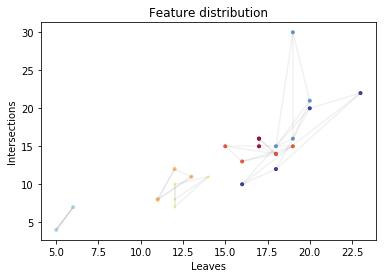

In [174]:
plot_features(X, y)
plot_lines(X, y)
plot_title()

## Построение классификатора

In [177]:
#plot_features(X, y)
def plot_dec_function(X, clf):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap = cmap, alpha = 0.3)

train_idx: [ 1  2  3  4  5  7  8 10 11 12 13 14 16 17 19 20 21 23 24 26 27]
test_idx : [ 0  6  9 15 18 22 25]
test accuracy: 0.571428571429



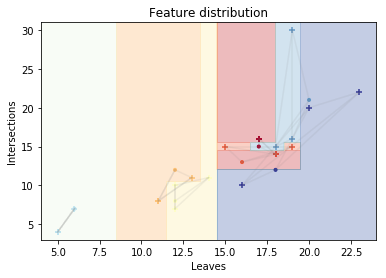

train_idx: [ 0  2  3  5  6  7  8  9 11 13 14 15 17 18 19 21 22 23 24 25 26]
test_idx : [ 1  4 10 12 16 20 27]
test accuracy: 0.571428571429



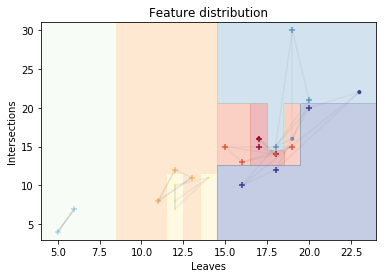

train_idx: [ 0  1  2  4  5  6  9 10 11 12 13 15 16 18 19 20 22 23 24 25 27]
test_idx : [ 3  7  8 14 17 21 26]
test accuracy: 0.428571428571



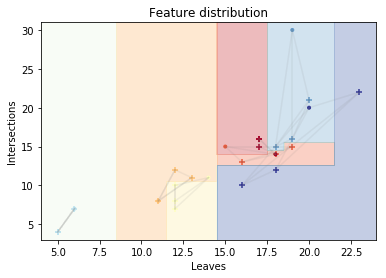

train_idx: [ 0  1  3  4  6  7  8  9 10 12 14 15 16 17 18 20 21 22 25 26 27]
test_idx : [ 2  5 11 13 19 23 24]
test accuracy: 0.428571428571



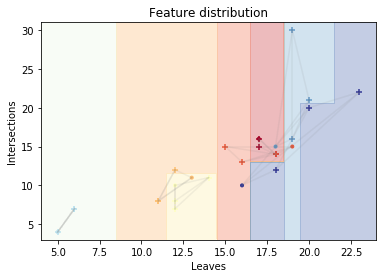

In [192]:
skf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 4)
skf.get_n_splits(X, y)
accuracy = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    accuracy.append(acc)
    
    plot_dec_function(X, clf)
    plot_features(X_train, y_train, '+')
    plot_features(X_test, y_test, '.')
    plot_lines(X, y)
    plot_title()
    print("train_idx: {}\ntest_idx : {}\ntest accuracy: {}\n".format(train_index, test_index, acc))
    plt.show()

In [194]:
print("Accuracy: {}\nMean accuracy: {}\nWorst accuracy: {}".format(accuracy, np.mean(accuracy), 1. / n_classes))

Accuracy: [0.5714285714285714, 0.5714285714285714, 0.42857142857142855, 0.42857142857142855]
Mean accuracy: 0.5
Worst accuracy: 0.142857142857
